# Analyzing Data with Pandas and Statsmodels

In this section of the tutorial, we will go through common ways to use Pandas and statsmodels to analyze data. The dataset we'll be analyzing comes from first experiment in the following paper:

Hamrick, J. B., Smith, K. A., Griffiths, T. L., & Vul, E. (2015). Think again? The amount of mental simulation tracks uncertainty in the outcome. In Proceedings of the 37th Annual Conference of the Cognitive Science Society. Austin, TX.

In this experiment, participants looked at a ball bouncing around in a box, and had to determine whether that ball would go through a hole in the wall or not:

![](images/experiment.png)

---

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

First, let's read in the data:

In [2]:
data = pd.read_csv("data/ball.csv")
data.head()

,pid,stim,hole_width,hole_class,condition,trial,goes_in,num_bounces,response,rt
0,0095f15b,B_0_0,200,far miss,7,26,False,0,False,1.439
1,0095f15b,B_0_1,100,far in,7,45,True,0,False,4.384
2,0095f15b,B_0_10,200,far in,7,24,True,0,True,1.523
3,0095f15b,B_0_11,100,close in,7,41,True,0,True,1.492
4,0095f15b,B_0_12,200,close in,7,33,True,0,True,3.008


The stimuli in this dataset vary based on the number of times the ball bounces, the margin by which it does or does not go in the hole, and the size of the hole itself. There are 48 initial starting trajectories for the ball (reflected by the `"stim"` column), four different ways the ball can go in or miss the hole (reflected by the `"hole_class"` column), and two hole sizes (reflected by the `"hole_width"` column).

## Querying

We can extract different types of judgments using the `.query()` method of a DataFrame, for example to pull out judgments only for trials in which the ball went in the hole:

In [3]:
goesin = data.query("goes_in == True")
goesin.head()

,pid,stim,hole_width,hole_class,condition,trial,goes_in,num_bounces,response,rt
1,0095f15b,B_0_1,100,far in,7,45,True,0,False,4.384
2,0095f15b,B_0_10,200,far in,7,24,True,0,True,1.523
3,0095f15b,B_0_11,100,close in,7,41,True,0,True,1.492
4,0095f15b,B_0_12,200,close in,7,33,True,0,True,3.008
8,0095f15b,B_0_2,200,far in,7,18,True,0,True,2.660


Now that we have a DataFrame containing only the data on trials in which the ball went in the hole, we can easily visualize them using built-in Pandas plotting methods, such as `.hist()`. For example, to view the histogram of response times:

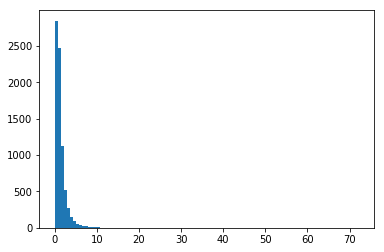

In [4]:
goesin['rt'].hist(grid=False, bins=100)

The $x$-axis has a really high limit here, suggesting we have some very large outliers:

In [5]:
goesin['rt'].max()

72.247

Indeed. We can also use query to pull out only those response times that are within a certain range, such as the 99% interval centered around the median:

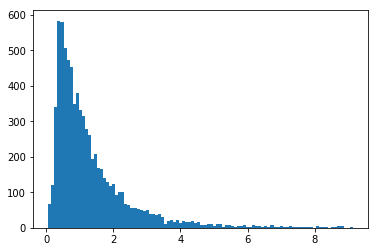

In [6]:
lo, hi = np.percentile(goesin["rt"], [0.5, 99.5])
data = data.query("rt > {} and rt < {}".format(lo, hi))
goesin = data.query("goes_in == True")
goesin['rt'].hist(grid=False, bins=100)

### Exercise

<div class="alert alert-success">
Using the query method, query for stimuli where the ball missed the hole by a small margin *and* bounced once, and then visualize the response times using a histogram.
</div>

In [7]:
# Your code here

## Grouping

It would be nice to look at not just histograms, but also response averages and standard deviations. This is very easy to do with the `.groupby()` operation of the DataFrame. This is a complex operation and can at times be confusing to understand, so I recommend reading throught he Pandas documentation on this concept: https://pandas.pydata.org/pandas-docs/stable/groupby.html

The basic idea is to split the DataFrame apart into separate DataFrames, apply some operation, and then recombine them. So, we can take this procedure to (for example), split the `fall` DataFrame apart into separate DataFrames for each stimulus, compute the average response, and then recombine:

In [8]:
# groupby stimulus, hole width, and hole class, and then compute the mean of the 'response' column for each group
mean_resp = data.groupby(["stim", "hole_width", "hole_class"])["response"].mean()
mean_resp.head()

stim   hole_width  hole_class
B_0_0  100         close in      0.925000
                   close miss    0.150000
                   far in        1.000000
                   far miss      0.000000
       200         close in      0.853659
Name: response, dtype: float64

Note that in the above operation, I've passed a list to the groupby operation---this tells it to group by unique values in *multiple* columns, so that we get one group for each stimulus and mass ratio.

Pandas comes with some built-in methods that can be applied to groups, like `.mean()`. But what if you wanted to use a function that wasn't predefined? We can easily do this using `.apply()`, which takes as an argument the function to execute. The following is equivalent to using `.mean()`:

In [9]:
data.groupby(["stim", "hole_width", "hole_class"])["response"].apply(np.mean).head()

stim   hole_width  hole_class
B_0_0  100         close in      0.925000
                   close miss    0.150000
                   far in        1.000000
                   far miss      0.000000
       200         close in      0.853659
Name: response, dtype: float64

We can provide any function which returns either a scalar (e.g., `np.mean`) or a Pandas `Series` object. The Series object is like a column of a DataFrame: it has labeled rows, but is only a single column. For example, we could write a function that returns a variety of statistics as a Series object:

In [10]:
def calc_stats(group):
    stats = pd.Series({
        "mean": group.mean(),
        "median": group.median(),
        "std": group.std(),
        "sem": scipy.stats.sem(group)
    })
    
    # this is so the column in the resulting DataFrame,
    # after using groupby, has a label
    stats.index.name = "statistic"

    return stats

In [11]:
resp_stats = data.groupby(["stim", "hole_width", "hole_class"])["response"].apply(calc_stats)
resp_stats.head()

stim   hole_width  hole_class  statistic
B_0_0  100         close in    mean         0.925000
                               median       1.000000
                               std          0.266747
                               sem          0.042176
                   close miss  mean         0.150000
Name: response, dtype: float64

### Exercise

<div class="alert alert-success">
Try grouping the `data` DataFrame by the number of bounces, the hole size, and the hole class, and then compute the mean **response time** of each of those groups.
</div>

In [12]:
# Your code here

## Massaging DataFrames

Coming back to our `resp_stats` object, let's say we want to pull out just the mean statistic. If we try doing this with `.query()`, as we saw before, we find it fails:

In [14]:
resp_stats_df = resp_stats.to_frame()
resp_stats_df.query("statistic == 'mean'")

response
stim   hole_width hole_class statistic          
B_0_0  100        close in   mean       0.925000
                  close miss mean       0.150000
                  far in     mean       1.000000
                  far miss   mean       0.000000
       200        close in   mean       0.853659
                  close miss mean       0.150000
                  far in     mean       1.000000
                  far miss   mean       0.000000
B_0_1  100        close in   mean       0.950000
                  close miss mean       0.268293
                  far in     mean       0.769231
                  far miss   mean       0.075000
       200        close in   mean       0.973684
                  close miss mean       0.666667
                  far in     mean       1.000000
                  far miss   mean       0.025641
B_0_10 100        close in   mean       0.950000
                  close miss mean       0.657895
                  far in     mean       0.800000
                  far miss   mean       0.050000
       200        close in   mean       0.950000
                  close miss mean       0.560976
                  far in     mean       1.000000
                  far miss   mean       0.000000
B_0_11 100        close in   mean       0.820513
                  close miss mean       0.736842
                  far in     mean       0.769231
                  far miss   mean       0.025000
       200        close in   mean       0.925000
                  close miss mean       0.564103
...                                          ...
B_2_6  100        far in     mean       0.625000
                  far miss   mean       0.157895
       200        close in   mean       0.750000
                  close miss mean       0.526316
                  far in     mean       0.804878
                  far miss   mean       0.350000
B_2_7  100        close in   mean       0.609756
                  close miss mean       0.300000
                  far in     mean       0.743590
                  far miss   mean       0.205128
       200        close in   mean       0.589744
                  close miss mean       0.375000
                  far in     mean       0.825000
                  far miss   mean       0.325000
B_2_8  100        close in   mean       0.550000
                  close miss mean       0.500000
                  far in     mean       0.473684
                  far miss   mean       0.175000
       200        close in   mean       0.658537
                  close miss mean       0.589744
                  far in     mean       0.825000
                  far miss   mean       0.230769
B_2_9  100        close in   mean       0.475000
                  close miss mean       0.875000
                  far in     mean       0.692308
                  far miss   mean       0.175000
       200        close in   mean       0.600000
                  close miss mean       0.512821
                  far in     mean       0.850000
                  far miss   mean       0.325000

[384 rows x 1 columns]

What gives? The issue is that `resp_stats` isn't a DataFrame---it's a Series object, which means it doesn't have any columns that we can query! There are two options we can use to turn it into a DataFrame.

### Converting Between Columns and Indicies

The first option is to use the `.to_frame()` method:

In [ ]:
resp_stats.to_frame("value").head()

This is now a DataFrame, but it still doesn't have a column for `"statistic"` -- that's part of the index. To turn columns in the index to real columns in the DataFrame, we can use the `.reset_index()` method:

In [ ]:
resp_stats.to_frame("value").reset_index().head()

Now we can query for the mean:

In [ ]:
resp_stats.to_frame("value").reset_index().query("statistic == 'mean'").head()

And we can make columns part of the index again by using the `.set_index()` method:

In [ ]:
resp_stats\
    .to_frame("value")\
    .reset_index()\
    .query("statistic == 'mean'")\
    .set_index(["stim", "hole_width", "hole_class"])\
    .head()

Note that we don't really need to use `.set_index()` here again; I am showing it for demonstration purposes only---though it certainly does come in handy sometimes! If we really wanted to to what we had just done, it would be better to pass just the `"statistic"` column to `.reset_index()` in the first place:

In [ ]:
resp_stats.to_frame("value").reset_index("statistic").query("statistic == 'mean'").head()

### Stacking, Unstacking, and Pivoting DataFrames

The other option to isolate only the mean values is to "unstack" the `"statistic"` column. This converts it from a part of the index to a series of columns:

In [ ]:
resp_stats.unstack("statistic").head()

From here, we can easily query the mean column by just indexing into the DataFrame:

In [ ]:
resp_stats.unstack("statistic")["mean"].head()

This method also makes it easy to select multiple columns at once:

In [ ]:
resp_stats.unstack("statistic")[["mean", "std"]].head()

And we can convert it back to a Series object using the `.stack()` method:

In [ ]:
resp_stats.unstack("statistic")[["mean", "std"]].stack().head()

## Computing Statistics with Statsmodels

For basic statistic, the [statsmodels package](http://www.statsmodels.org/stable/index.html) is a great resource. It doesn't have quite the breadth of statistical functions available as are present in R, but for quick and easy linear modeling it can be quite useful.

Let's take a look at whether people's response time varies as a function of the hole class and width. First, however, we'll compute log response times to work with, because response time is often very close to log-normally distributed:

In [ ]:
# create a new column in `mass` that reflects whether responses are equal to the true answer
data["log_rt"] = np.log(data["rt"])
data.head()

In [ ]:
data["log_rt"].hist(grid=False, bins=100)

We can see from the plot that the response times are almost, though not quite, normally distributed. A Q-Q plot will help us see this further:

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data["log_rt"], line='45');

Ok, now we are ready to try building our first model. We'll create a binomial GLM predicting accuracy as a function of the true ratio:

In [ ]:
model = smf.ols("log_rt ~ hole_class * hole_width", data=data).fit()
model.summary()

We can also compute an ANOVA:

In [ ]:
from statsmodels.stats.api import anova_lm
anova_lm(model)

We can see from the results that both the hole size and the margin by which the ball does/does not go in the hole significantly affect response times, and that there is also an interaction between these variables.

(Note: there is a major issue with this analysis, which is that it doesn't take into account the fact that we have multiple measures of each stimulus and multiple responses from each participant. A better analysis would be to use a mixed-effects model, but statsmodels unfortunately doesn't have good support for that.)

### Exercise: Putting it all together!

<div class="alert alert-success">
<ul>
<li> Compute average log response times and responses for each stimulus, hole width, and hole class pair (averaging across participants).
<li> Plot the relationship between average responses ($x$-axis) and average log response times ($y$-axis).
<li> Use statsmodels to determine whether there is a relationship between average responses and average log response times. Is the relationship first order or second order?
</ul>
</div>

* Hint #1: you can create a DataFrame out of series objects like so: `df = pd.DataFrame({"col_a": a, "col_b": b})`
* Hint #2: to include a second-order factor in your linear model, you can use `I` like so: `I(varname ** 2)`

In [ ]:
# Your code here